# 训练分类器

我们已经了解了如何定义神经网络，计算损耗并更新网络权重。

现在你可能在想：

## 有关数据的问题


通常，当处理图像、文字、音频或者视频数据的时候，可以使用标准的python包将数据加载到numpy数组中。然后可以将这个数组转换成一个`torch.*Tensor`。

- 对于图像，Pillow，OpenCV等软件包很有用
- 对于音频，scipy，librosa等包很有用
- 对于文字，直接使用Python或者Cython加载，或者NLTK和SpaCY都可行

视觉很特殊，我们创建了一个名为`torchvision`的包，它提供了数据加载器`torchvision.datasets`，可以从常见的数据集加载数据，如Imagenet, CIFAR10, MNIST 等；还提供用于图像的数据转换器`torch.utils.data.DataLoader`。

这提供了极大的便利而且能够避免编写样板代码。

在本教程中，我们将使用CIFAR10数据集。它有类：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’,‘truck’。
CIFAR-10中的图像尺寸为3x32x32，即尺寸为32x32像素的3通道彩色图像。

![cifar10](https://pytorch.org/tutorials/_images/cifar10.png)

   cifar10

## 训练图像分类器


我们将按顺序执行以下步骤：

1. 用`torchvision`加载并规格化CIFAR10的训练和测试数据集
2. 定义卷及神经网络(CNN)
3. 定义损失函数
4. 使用训练数据训练网络
5. 使用测试数据测试网络

### 1. 加载并规格化CIFAR10

用`torchvision`加载CIFAR10非常容易。

In [1]:
from time import time

import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

torchvision数据集的输出是`[0,1]`区间PILImage图像。我们把它们转换为规格化`[-1, 1]`区间的张量。



In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


我们来展示一些训练图像，挺有趣的。



truck truck  bird  bird


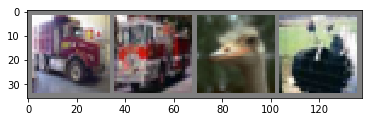

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 定义卷及神经网络(CNN)

从前文的神经网络章节复制代码，修改，让它采用3通道图像(而不是之前定义的1通道)



In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. 定义损失函数

使用交叉熵损失和带有动量的SGD。


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 训练网络

事情开始变得有趣了。
我们只需循环遍历数据迭代器，并将输入提供给网络并进行优化。



In [6]:
for epoch in range(2):  # loop over the dataset multiple times
    ts = time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Epoch {0} finished in {1:.3f} second(s)'.format(epoch, time()-ts))

print('Finished Training')

[1,  2000] loss: 2.237
[1,  4000] loss: 1.909
[1,  6000] loss: 1.723
[1,  8000] loss: 1.601
[1, 10000] loss: 1.531
[1, 12000] loss: 1.477
Epoch 0 finished in 75.642 second(s)
[2,  2000] loss: 1.404
[2,  4000] loss: 1.372
[2,  6000] loss: 1.347
[2,  8000] loss: 1.353
[2, 10000] loss: 1.296
[2, 12000] loss: 1.263
Epoch 1 finished in 72.981 second(s)
Finished Training


### 5. 使用测试数据对网络进行测试

在训练数据集上已经对网络进行了两个纪元(epoch)的训练。
但是我们还要进行检查，看看这个网络是否真的学会了什么。

用这个神经网络进行预测，检查它输出的分类标签是否和实际值一直。如果预测正确，把样本加到正确预测列表。

好了，第一步先从测试集显示一个图像，熟悉一下。



GroundTruth:    cat  ship  ship plane


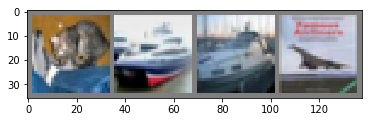

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

好的，现在让我们看看神经网络认为上面这些例子是什么：



In [8]:
outputs = net(images)

输出值是10重类型的能量值。
一个类型的能量值越高，就表明网路越倾向于认为图片是这种类型的。
那么，让我们得到最高能量值的序号：



In [9]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


结果似乎还行。

让我们看看这个网络如何预测整个测试数据集。



In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 2500/2500 [00:05<00:00, 420.29it/s]

Accuracy of the network on the 10000 test images: 53 %


看起来比随便猜(从10个类型中随机选一个的准确度是10%)强。
这个网络似乎学会了一些东西。

嗯，哪些类型表现好，哪些不好：



In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

100%|██████████| 2500/2500 [00:05<00:00, 418.22it/s]

Accuracy of plane : 29 %
Accuracy of   car : 68 %
Accuracy of  bird : 28 %
Accuracy of   cat : 42 %
Accuracy of  deer : 43 %
Accuracy of   dog : 45 %
Accuracy of  frog : 70 %
Accuracy of horse : 56 %
Accuracy of  ship : 81 %
Accuracy of truck : 73 %


好的，接下来呢？

我们如何在GPU上运行这些神经网络？

## 在GPU上训练

就像将Tensor转到GPU一样，可将神经网络转到GPU。

如果有可用的CUDA，我们首先获取第一个可见的cuda设备：

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


本节的其余部分假定`device`是一个CUDA设备。

然后这些方法将递归遍历所有模块并将其参数和缓冲区转换为CUDA张量：

```python
net.to(device)
```

记住还得将每一步的输入和目标发送到GPU：

```python
inputs, labels = inputs.to(device), labels.to(device)
```

可能观察不到与CPU相比的有明显加速，那是因为的网络太小。

### 练习

尝试增加网络的宽度（第一个`nn.Conv2d`的第二个参数，第二个`nn.Conv2d`的第一个参数——它们应是相同的数值），看看能获得什么样的加速。


**达到的目标：**

- 在高层次上理解PyTorch的Tensor库和神经网络。
- 训练一个小型的图像分类神经网络


In [13]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net2 = Net2()
net2.to(device)


for epoch in range(2):  # loop over the dataset multiple times
    ts = time()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print('Epoch {0} finished in {1:.3f} second(s)'.format(epoch, time()-ts))

print('Finished Training')


[1,  2000] loss: 2.305
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.304
[1, 10000] loss: 2.303
[1, 12000] loss: 2.305
Epoch 0 finished in 72.346 second(s)
[2,  2000] loss: 2.304
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.303
[2, 10000] loss: 2.304
[2, 12000] loss: 2.305
Epoch 1 finished in 63.276 second(s)
Finished Training


## 在多个GPU上进行训练

如果想使用所有的GPU来大幅加速，请参考 data_parallel_tutorial。

## 下一步怎么办？

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_